# Reinforcement Learning with:
- Monte Carlo Simulation Algorithm
- SARSA Algorithm
- Q Learning Algorithm

# Environment and Mission 

*The goal is for the agent to learn how to navigate the state space to reach the end goal of retrieving the frisbee*
<br></br>

<U>**Within Action Space, the following actions are defined:**</U>

**'L':** Move left

**'D':** Move down

**'R':** Move right

**'U':** Move up

*If agent attempts to leave the grid, when at the edges, program would set the new state as the old state. Basically it will not move
<br></br>

<U>**Map**:</U>
    
    S  .  .  .
    
    .  H  .  H
    
    .  .  .  H
    
    H  .  .  E
<br></br>
<U>**Rewards**:</U>

Reach goal: +1

Reach hole: -1

Traversing frozen surface: 0 


---

# Building Environment


### Importing relevant packages

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import statistics as st
import pandas as pd
import math
import time
import pygame
from IPython.display import display, update_display, clear_output
from queue import PriorityQueue

pd.set_option('display.max_columns', None) # Set to view full dataframe

### Creating Grid Environment

#### Creating Grid Class

In [3]:
class Grid:

    # Takes in variables of rows, cols and start state of agent
    def __init__(self, rows, cols, start):
        self.rows = rows
        self.cols = cols
        self.s = start
        self.i = start[0]
        self.j = start[1]
    
    # Fucntion that allows user to set rewards and actions allowed at given states
    def set(self, rewards, actions):
        self.rewards = rewards
        self.actions = actions

    # Function that allows user to set state of agent
    def set_state(self,s):
        self.i = s[0]
        self.j = s[1]
    
    # Function that fetches current state of agent
    def current_state(self):
        return(self.i, self.j)
    
    # Function that checks if agent is in a terminal state (if current state of agent is in a terminal state: hole / goal state, then function returns True)
    def is_terminal(self, s):
        return s not in self.actions
    
    # Function that fetches the possible actions the agent can take at a given state s
    def possible_actions(self, s):
        return self.actions[s]
    
    # Moves the agent in the state space based on the action taken by the agent
    def move(self, action):
        if action in self.actions[(self.i, self.j)]:
            if action == 'U':
                self.i -= 1
            elif action == 'D':
                self.i += 1
            elif action == 'R':
                self.j += 1
            elif action == 'L':
                self.j -= 1
    
    # Gets reward of the current state of agent
    def get_rewards(self):
        reward = self.rewards.get((self.i, self.j), 0)
        return reward
    
    # Undo move of agent (Function isn't used but put in place if needed)
    def undo_move(self, action):
        if action == 'U':
            self.i += 1
        elif action == 'D':
            self.i -= 1
        elif action == 'R':
            self.j -= 1
        elif action == 'L':
            self.j += 1
        # assert(self.current_state() in self.all_states())

    def render(self):
        # Define colors
        WHITE = (255, 255, 255)
        BLACK = (0, 0, 0)
        BLUE = (0, 0, 255)
        GREEN = (0, 255, 0)
        RED = (255, 0, 0)

        # Define tile and agent sizes
        TILE_SIZE = 50
        AGENT_RADIUS = 20

        # Clear scrreen
        screen = pygame.display.set_mode((50 * self.rows, 50 * self.cols))
        screen.fill(WHITE)

        for i in range(self.rows):
            for j in range(self.cols):
                if (i,j) in self.rewards:
                    if self.rewards[(i, j)] == 1:
                        color = GREEN
                    elif self.rewards[(i, j)] == -1:
                        color = BLACK
                else:
                    if (i, j) == self.s:
                        color = WHITE
                    else:
                        color = BLUE

                rect = pygame.Rect(j * TILE_SIZE, i * TILE_SIZE, TILE_SIZE, TILE_SIZE)
                pygame.draw.rect(screen, color, rect)
            
        
        agent_row = self.current_state()[0]
        agent_col = self.current_state()[1]
        agent_center = ((agent_col + 0.5) * TILE_SIZE, (agent_row + 0.5) * TILE_SIZE)
        pygame.draw.circle(screen, RED, agent_center, AGENT_RADIUS)
        pygame.display.flip()
        pygame.time.wait(50)
            
    # To reset agent to be at starting state - (0, 0) in our specific example
    def reset(self):
        self.set_state((0,0))

#### Environment Characteristics class

In [4]:
class env_characteristics():
    def __init__(self, no_of_rows, no_of_cols, percentage_of_holes):
        self.rows = no_of_rows
        self.cols = no_of_cols
        self.actions = {}
        self.holes = []
        self.rewards = {}
        self.start_state = (0, 0)
        self.end_state = (no_of_rows - 1, no_of_cols - 1)
        self.percentage_holes = percentage_of_holes
     

    # Function that creates legal actions dictionary (similar to hard-coded version in env1)
    def create_legal_actions(self): 
        
        actions = {}
        for i in range(self.rows):
            for j in range(self.cols):
                action_space = ['D', 'L', 'R', 'U']

                if i == 0 and j == 0:
                    illegal_action = ('L', 'U')
                    for item in illegal_action:
                        action_space.remove(item)
                    
                    actions[(i, j)] = tuple(action_space)

            
                elif i == 0 and j == self.cols-1:
                    illegal_action = ('R', 'U')
                    for item in illegal_action:
                        action_space.remove(item)
                    actions[(i, j)] = tuple(action_space)
                    
                elif i == self.rows-1 and j == 0:
                    illegal_action = ('D', 'L')
        
                    for item in illegal_action:
                        action_space.remove(item)
                    actions[(i, j)] = tuple(action_space) 
                        
                    
                elif i == self.rows-1 and j == self.cols-1:
                    illegal_action = ('D', 'R')
                    
                    for item in illegal_action:
                        action_space.remove(item)
                    actions[(i, j)] = tuple(action_space) 
                                            

                elif i == 0:
                    illegal_action = ('U')

                    for item in illegal_action:
                        action_space.remove(item)
                    actions[(i, j)] = tuple(action_space) 
                        

                elif j == 0:
                    illegal_action = ('L')

                    for item in illegal_action:
                        action_space.remove(item)
                    actions[(i, j)] = tuple(action_space) 


                elif i == self.rows-1:
                    illegal_action = ('D')

                    for item in illegal_action:
                        action_space.remove(item)
                    actions[(i, j)] = tuple(action_space) 
                        

                elif j == self.cols-1:
                    illegal_action = ('R')

                    for item in illegal_action:
                        action_space.remove(item)
                    actions[(i, j)] = tuple(action_space) 
                        
            
                else:
                    illegal_action = ()
                    
                    for item in illegal_action:
                        action_space.remove(item)
                    actions[(i, j)] = tuple(action_space) 


        return actions
    

    # Funtion that creates rewards dictionary (similar to hard-coded version in env1)
    # Rewards list will dictate where holes are placed - hence we need to ensure holes are populated without blocking
    # We do so by running the Astar algorithm to check if there is possible path everytime we place a new hole
    def createActionsRewards(self):
        actions_list = self.create_legal_actions()
        number_of_holes = int(self.percentage_holes * self.rows * self.cols)

        # Create rewards dictionary
        rewards = {}
        hole_list = []

        # Add rewards for end state
        rewards[self.end_state] = 1

        # Run loop to create correct number of holes 
        for i in range(number_of_holes):    
            # Initialise random hole variable
            random_hole = 0
            
            # Generate random hole again if random hole has already been made
            while random_hole not in hole_list:
                # If random hole removed from actions list already, generate another hole
                # Generate new hole if random hole selected is start state
                while random_hole not in actions_list or random_hole == self.start_state or random_hole == self.end_state:
                    random_hole = (random.randint(0, self.rows - 1), random.randint(0, self.cols - 1))
                
                state, actions = random_hole, actions_list[random_hole]

                # Delete hole from actions-list to run ASTAR algo
                del actions_list[random_hole]

                # If astar returns viable path, then append hole and note it in rewards dictionary
                viable_path = astar_algo(self.start_state, self.end_state, self.rows, actions_list)
                if viable_path != None:
                    hole_list.append(state)
                    rewards[state] = -1

                # else, run main loop again
                else:
                    actions_list[state] = actions
                    random_hole = 0 # Initialised hole that will never be in actions list so second while loop will run
                
        # Remove end state to fit definition of environment        
        del actions_list[self.end_state] # Done here and not before because Astar algo requires endstate to be in actions_list
        
        return actions_list, rewards

##### Astar Algorithm for building random holes in environment

In [5]:
def astar_algo(start_coord, end_coord, grid_size, actions):
    
    # Heuristic function that calculates the Manhattan distance between two points
    def heuristic(s, e):
        return abs(e[0] - s[0]) + abs(e[1] - s[1])
    
    # Converts coordinate states to number states -> (0,0) = 0, (1,0) = 4
    def coord_to_state(coord, grid_size):
        return coord[0] * grid_size + coord[1]

    start_state = coord_to_state(start_coord, grid_size)
    end_state = coord_to_state(end_coord, grid_size)  
    
    # Create g_score dict 
    g_score = {start_state: 0}
    # Activate f_score which is g_score + heuristic score
    f_score = {start_state: heuristic(start_coord, end_coord)}

    # Create queue to select states with lowest fscore for finding optimal path
    open_list = PriorityQueue()
    open_list.put((f_score[start_state], start_state))
    closed_list = set()

    # came_from dictionary to return shortest path later
    came_from = {}
    
    while open_list.empty() == False:
        
        # Get state of the lowest fscore
        current_state = open_list.get()[1]

        # Check if reached end goal
        if current_state == end_state:
            path = []

            # If reached, return shortest path
            while current_state != start_state:
                path.append(current_state)
                current_state = came_from[current_state]
            path.append(start_state)
            return path[::-1]
        
        # Add current_state to closed_list - to keep track of visited
        closed_list.add(current_state)


        neighbours = []
        row, col = divmod(current_state, grid_size)
        # print("current state: {}, coord: {}".format(current_state, (row, col)))
        
        # Append neighbouring states to neighbours list
        if row > 0:
            if (row, col) in actions:
                above_state = (row - 1, col)
                if above_state in actions:
                    neighbours.append(current_state - grid_size) # State above

        if row < grid_size - 1:
            if (row, col) in actions:
                below_state = (row + 1, col)
                if below_state in actions:
                    neighbours.append(current_state + grid_size) # State below

        if col > 0:
            if (row, col) in actions:
                left_state = (row, col - 1)
                if left_state in actions:
                    neighbours.append(current_state - 1) # State on left

        if col < grid_size - 1:
            if (row, col) in actions:
                right_state = (row, col + 1)
                if right_state in actions:
                    neighbours.append(current_state + 1) # State on right

        # Loop through neighbour states
        for neighbour_state in neighbours:
            if neighbour_state in closed_list:
                continue
        
            # Calculate tentative g-score of neighbour
            tentative_g_score = g_score[current_state] + 1
            if neighbour_state not in g_score or tentative_g_score < g_score[neighbour_state]:
                # Update scores and came_from dictionary
                g_score[neighbour_state] = tentative_g_score
                f_score[neighbour_state] = tentative_g_score + heuristic((neighbour_state // grid_size, neighbour_state % grid_size), end_coord)
                came_from[neighbour_state] = current_state 

                open_list.put((f_score[neighbour_state], neighbour_state))

    # If no path, return none
    return None

#### Creating Grid Environment Function


In [6]:
def standard_grid(rewards, actions, rows, cols, start_state):
    # define a grid that describes the reward for arriving at each state
    # and possible actions at each state
    # the grid looks like this
    # S means start position
    # E means the end states

        # S  .  .  .
        # .  H  .  H
        # .  .  .  H
        # H  .  .  E

    g = Grid(rows, cols, start_state) #(rows, cols, start_state)
    g.set(rewards, actions)
    return g

#### Creating Environment 1 - 4 x 4 Grid (With specific holes in environment)

In [7]:
# Environment Characteristics
# no. of rows & cols of grid
no_of_rows = 4
no_of_cols = 4

# Full action space
action_space = ('D', 'U', 'L', 'R')

# Assigned start state
start_state = (0, 0)

# Define rewards at specific states (punishment yields negative rewards)
# rewards at given states (in dictionary form)
rewards = {(1, 1): -1, # hole
           (1, 3): -1, # hole
           (2, 3): -1, # hole
           (3, 0): -1, # hole
           (3, 3): 1} # frisbee

# Define legal (possible) actions at each state
# States that depict terminal state (hole / end goal) are commented because this will tie in with the .is_terminal() function under class Grid
actions = {
        (0, 0): ('D', 'R'), # Start_state
        (0, 1): ('D', 'R', 'L'), 
        (0, 2): ('D', 'R', 'L'),
        (0, 3): ('D', 'L'),
        (1, 0): ('D', 'R', 'U'),
        #(1, 1): ('D', 'R', 'L', 'U'), #Hole
        (1, 2): ('D', 'R', 'L', 'U'),
        #(1, 3): ('D', 'U', 'L'), #Hole
        (2, 0): ('D', 'U', 'R'),
        (2, 1): ('D', 'R', 'L', 'U'),
        (2, 2): ('D', 'R', 'L', 'U'),
        #(2, 3): ('D', 'U', 'L'), #Hole
        #(3, 0): ('U', 'R', ), #Hole
        (3, 1): ('U', 'R', 'L'),
        (3, 2): ('U', 'R', 'L'),
        #(3, 3): (), #End-State (frisbee)
}


# Create 4x4 Grid environment
env1 = standard_grid(rewards, actions, no_of_rows, no_of_cols, start_state) 

# Reset environment to start state defined as (0,0) in .reset() function
env1.reset()

print(type(env1))

<class '__main__.Grid'>


##### --- Function testing ---

In [8]:
# Test if .is_terminal() function works
    # Terminal States: 1,1  1,3  2,3  3,0  3,3
print(env1.is_terminal((2, 0)))
print(env1.is_terminal((3, 0)))


# Test .move()
env1.reset()
state_before = env1.current_state()
action = env1.move('D')
state_after = env1.current_state()
print('Original State: {}, After taking action: {}'.format(state_before, state_after))


# Test loop to stop moving when environment reaches terminal state
while env1.is_terminal(env1.current_state()) == False:
    a = action_space[(random.randint(0, (len(action_space)-1)))]
    state_b = env1.current_state()
    env1.move(a)
    state_a = env1.current_state()
    
    print("State before: {}, State After taking action '{}': {}".format(state_b, a, state_a))

else:
    print('Reached terminal state {}'.format(env1.current_state()))

False
True
Original State: (0, 0), After taking action: (1, 0)
State before: (1, 0), State After taking action 'U': (0, 0)
State before: (0, 0), State After taking action 'U': (0, 0)
State before: (0, 0), State After taking action 'L': (0, 0)
State before: (0, 0), State After taking action 'U': (0, 0)
State before: (0, 0), State After taking action 'L': (0, 0)
State before: (0, 0), State After taking action 'U': (0, 0)
State before: (0, 0), State After taking action 'U': (0, 0)
State before: (0, 0), State After taking action 'L': (0, 0)
State before: (0, 0), State After taking action 'U': (0, 0)
State before: (0, 0), State After taking action 'D': (1, 0)
State before: (1, 0), State After taking action 'L': (1, 0)
State before: (1, 0), State After taking action 'U': (0, 0)
State before: (0, 0), State After taking action 'L': (0, 0)
State before: (0, 0), State After taking action 'R': (0, 1)
State before: (0, 1), State After taking action 'D': (1, 1)
Reached terminal state (1, 1)


#### Extended Implementation: Creating Environment 2 - 10 x 10 Grid

<strong> Creating Env2, Legal Actions and Rewards List  </strong>

In [9]:
nrows = 10
ncols = 10
p_holes = 0.25
start_state_env_2 = (0,0)

# Creating legal actions and rewards list to parse into standard_grid class
actions_env2, rewards_env2 = env_characteristics(nrows, ncols, p_holes).createActionsRewards()

In [10]:
# Create 10x10 Grid environment
env2 = standard_grid(rewards_env2, actions_env2, nrows, ncols, start_state_env_2) 

# Reset environment to start state defined as (0,0) in .reset() function
env2.reset()

##### --- Function testing ---

In [11]:
env2.actions
env2.rewards

{(9, 9): 1,
 (6, 4): -1,
 (5, 9): -1,
 (3, 0): -1,
 (0, 4): -1,
 (7, 5): -1,
 (1, 7): -1,
 (3, 7): -1,
 (4, 7): -1,
 (9, 0): -1,
 (3, 5): -1,
 (4, 2): -1,
 (0, 6): -1,
 (2, 2): -1,
 (8, 7): -1,
 (6, 5): -1,
 (7, 8): -1,
 (9, 7): -1,
 (1, 2): -1,
 (3, 1): -1,
 (7, 7): -1,
 (0, 5): -1,
 (3, 6): -1,
 (1, 0): -1,
 (8, 2): -1,
 (8, 4): -1}

# Q table, Returns table and Policy

### Q table Function

*Q table is built as a dataframe for easier referencing: there were problems with referencing when building a multi nested dictionary*

In [12]:
def create_qtable(no_of_rows, no_of_cols, action_space):
    # Creates Q table as a nested dictionary
    Q = {}
    for i in range(no_of_rows):
        for j in range(no_of_cols):
            Q[(str(i) + str(j))] = 0
    
    action_space_dic = {}
    for item in action_space:
        action_space_dic[item] = 0
        

    for k, v in Q.items():
        Q[k] = action_space_dic
    
    # Converts Q table into a dataframe
    Q = pd.DataFrame(data = Q)
        
    return Q

### Returns table Function


*Returns table is built as a dataframe for easier referencing: there were problems with referencing when building a multi nested dictionary*

In [13]:
def create_returnstable(no_of_rows, no_of_cols, action_space):
    # Creates Returns table as a nested dictionary
    returns = {}
    for i in range(no_of_rows):
        for j in range(no_of_cols):
            returns[(str(i) + str(j))] = 0
    
    action_space_dic = {}
    for item in action_space:
        action_space_dic[item] = []
        

    for k, v in returns.items():
        returns[k] = action_space_dic
    
    # Converts Returns table into a dataframe
    returns = pd.DataFrame(data = returns)
        
    return returns

### Epsilon Greedy Policy

In [14]:
# Select an action for the agent to take. Each action has a minimum probability of (epsilon / no. of actions) of being selected
# Optimal action has a higher probability of being selected
def epsilon_soft(Qtable, env, epsilon, currentstate):

    prob = epsilon # sum of minimum prob of selecting all actions in action space

    # Set a random probability to determine which actions are being selected
    random_prob = random.random()
    best_actions = []
    valid_q_values = []

    # Finding max q value at the specific state for legal actions
    state_f = str(currentstate[0]) + str(currentstate[1]) # Formatted state
    for legal_action in env.actions[currentstate]:
        valid_q_values.append(Qtable.at[legal_action, state_f])
        max_q_value = max(valid_q_values)

    # Appending max q value of legal actions to best_actions list
    for item in Qtable[Qtable[state_f] == max_q_value].index.values:
        if item in env.actions[currentstate]:
            best_actions.append(item)
        else:
            continue
    
    # When random_prob =< sum of min prob of all actions, randomly select action
    if random_prob <= prob:
        # Select random action from legal actions
        valid_actions = env.actions[currentstate]
        action = valid_actions[(random.randint(0, (len(valid_actions)-1)))]
        return action
            
    # If random_prob > prob, then select legal action with highest q value
        # Other problems that this code solves:
            # 1. When more than 1 action has the same q value - select the action randomly
    else:
        action = best_actions[random.randint(0, len(best_actions)-1)]
        return action

_______________________________________________________________________________________________________________________________

# First-visit Monte Carlo Without Exploring

###  Algorithm Class

In [490]:
class monte_carlo_sim:
    '''
    ** Please remember to reset Q and Returns table after simulation

        Functions:
        # Fetches Qtable ->                            .fetchQtable()    
        # Fetches Returns Table ->                     .fetchReturnstable() 
        # Run simulation ->                            .simulate(no_of_episodes, epsilon, gamma)
        # Resets Qtable and Returns Table ->           .resettables()      
    '''
    def __init__(self, env):
        self.env = env
        # Create Q and Returns table on creating class
        self.Qtable_monte = create_qtable(self.env.rows, self.env.cols, action_space)
        self.Returns = create_returnstable(self.env.rows, self.env.cols, action_space)
        self.results = {} # Initialise results dictionary to analyse results
        self.number_of_states = self.env.rows * self.env.cols
        
    # Returns Qtable
    def fetchQtable(self):
        return self.Qtable_monte
    
    # Returns Returns table
    def fetchReturnstable(self):
        return self.Returns
    
    # Reset Q and Returns table by creating empty tables
    def resettables(self):
        self.Qtable_monte = create_qtable(self.env.rows, self.env.cols, action_space)
        self.Returns = create_returnstable(self.env.rows, self.env.cols, action_space)

    # Run monte carlo simulation
    def simulate(self, no_of_episodes, epsilon, gamma):
        self.results = {} # Reset results table for new simulation
        visited = set() # Create set to record the percentage of environment explored - for results analysis
        
        for n in range(no_of_episodes):  
            start_time = time.time() # Record start time of episode for results analysis
            
            episode = []
            G = 0
            
            # Reset environment to start state for each episode
            self.env.reset()

            # Loop so agent moves through state space until it reaches a terminal state (hole / end goal)
            # Store episode path (states, actions and rewards) in episode list
            while self.env.is_terminal(self.env.current_state()) == False:
                state = self.env.current_state()
                # print(state)
                action = epsilon_soft(self.Qtable_monte, self.env, epsilon, state)
                # Move agent based on selected action
                
                self.env.move(action)
                # Retrieve reward
                reward = self.env.get_rewards()
                
                # Render pygame visualisation
                # self.env.render()

                # Append all results to episode list so that backpropogation of rewards can be done later
                episode.append((state, action, reward))

            # Reverse episode list so looping is easier
            episode_reversed = episode[::-1]
            # Create a temporary list to use for checking if there are repeated visits to states
            temp_lst = [item[0] for item in episode_reversed]

            ## Code for Results Analysis
            # Record end time and time taken for episode to complete
            end_time = time.time()
            elapsed_time = end_time - start_time
            found_reward = False
            # For results analysis
            for j in range(len(episode)):
                state = episode[j][0]
                visited.add(state)

                if episode[j][2] == 1:
                    found_reward = True
            
            
            # print('Episode Number: {} / {}'.format(i + 1, no_of_episodes))

            total_reward = 0 # For results analysis

            # Loop through episodes in reverse (T-1 -> T-2 -> ... -> 0)
            for i in range(len(episode_reversed)):
                state = episode_reversed[i][0]
                state_f = str(state[0]) + str(state[1]) # state but formatted for referencing in dataframe
                act_taken = episode_reversed[i][1]
                r = episode_reversed[i][2]

                G = gamma*G + r

                # print(episode_reversed)

                total_reward += G # For results analysis

                # For first visit to state, append G to the Returns dataframe
                if state not in temp_lst[i+1:]:
                    self.Returns.at[act_taken, state_f] = self.Returns.at[act_taken, state_f] + [G]
                    # print(Returns.at[act_taken, state_f])
                else:
                    # Else, move on to next step in epsisode
                    continue
            
            # For results analysis
            episode_number = n + 1
            self.results[episode_number] = [elapsed_time, found_reward, '{} out of {}'.format(len(visited), self.number_of_states), total_reward]

            # For progress tracking
            clear_output(wait = True)
            display('Progress: {} / {}'.format(n+1, no_of_episodes))

            # Update Q table with average returns for each state and action
            for state in self.Qtable_monte.columns.values:
                for action in self.Qtable_monte.index.values:
                    if len(self.Returns.at[action, state]) != 0:
                        self.Qtable_monte.loc[action, state] = st.mean(self.Returns.at[action, state])
                    else:    
                        continue

        # Uncomment if self.env.render() is not commented
        # pygame.quit()

    # Run monte carlo simulation better
    def simulate_better(self, no_of_episodes, max_epsilon, min_epsilon, decay_rate, gamma):
        self.results = {} # Reset results table for new simulation
        visited = set() # Create set to record the percentage of environment explored - for results analysis
        
        for n in range(no_of_episodes):  
            start_time = time.time() # Record start time of episode for results analysis
            
            episode = []
            G = 0

            # Set epsilon and for it to decay over episodes
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*math.exp(-decay_rate*n)
            
            # Reset environment to start state for each episode
            self.env.reset()

            # Loop so agent moves through state space until it reaches a terminal state (hole / end goal)
            # Store episode path (states, actions and rewards) in episode list
            while self.env.is_terminal(self.env.current_state()) == False:
                state = self.env.current_state()
                # print(state)
                action = epsilon_soft(self.Qtable_monte, self.env, epsilon, state)
                # Move agent based on selected action
                
                self.env.move(action)
                # Retrieve reward
                reward = self.env.get_rewards()
                
                # Render pygame visualisation
                # self.env.render()

                # Append all results to episode list so that backpropogation of rewards can be done later
                episode.append((state, action, reward))

            # Reverse episode list so looping is easier
            episode_reversed = episode[::-1]
            # Create a temporary list to use for checking if there are repeated visits to states
            temp_lst = [item[0] for item in episode_reversed]

            ## Code for Results Analysis
            # Record end time and time taken for episode to complete
            end_time = time.time()
            elapsed_time = end_time - start_time
            found_reward = False
            # For results analysis
            for j in range(len(episode)):
                state = episode[j][0]
                visited.add(state)

                if episode[j][2] == 1:
                    found_reward = True

            # print('Episode Number: {} / {}'.format(i + 1, no_of_episodes))

            total_reward = 0 # For results analysis
            
            # Loop through episodes in reverse (T-1 -> T-2 -> ... -> 0)
            for i in range(len(episode_reversed)):
                state = episode_reversed[i][0]
                state_f = str(state[0]) + str(state[1]) # state but formatted for referencing in dataframe
                act_taken = episode_reversed[i][1]
                r = episode_reversed[i][2]

                G = gamma*G + r

                # print(episode_reversed)

                total_reward += G # For results analysis

                # For first visit to state, append G to the Returns dataframe
                if state not in temp_lst[i+1:]:
                    self.Returns.at[act_taken, state_f] = self.Returns.at[act_taken, state_f] + [G]
                    # print(Returns.at[act_taken, state_f])
                else:
                    # Else, move on to next step in epsisode
                    continue
            
            # For results analysis
            episode_number = n + 1
            self.results[episode_number] = [elapsed_time, found_reward, '{} out of {}'.format(len(visited), self.number_of_states), total_reward]

            # For progress tracking
            clear_output(wait = True)
            display('Progress: {} / {}'.format(n+1, no_of_episodes))

            # Update Q table with average returns for each state and action
            for state in self.Qtable_monte.columns.values:
                for action in self.Qtable_monte.index.values:
                    if len(self.Returns.at[action, state]) != 0:
                        self.Qtable_monte.loc[action, state] = st.mean(self.Returns.at[action, state])
                    else:    
                        continue

        # Uncomment if self.env.render() is not commented
        # pygame.quit()

###  Running Simulation

#####  Defining Parameters

In [472]:
epsilon_monte = 0.1 # Epsilon greedy probability 
gamma_monte = 0.9 # Rewards discount rate gamma
no_of_episodes_monte = 1000 # Number of episodes to be executed in simulation

#####  Creating instance of class & running simulation (Environment 1)

In [508]:
# Create instance of class with environment 1 (4x4 grid)
monte1 = monte_carlo_sim(env1)

# Run Monte Carlo simulation
monte1.simulate(no_of_episodes_monte, epsilon_monte, gamma_monte)

'Progress: 1000 / 1000'

#####  Qtable Results for *Monte Carlo Simulation* (Environment 1)

In [506]:
monte1.fetchQtable()

,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
D,-1.000000,-0.234668,-1.000000,-0.335483,0,0,0,0,0,0,0,-0.703940,0,-0.364813,0.00,0.0,0,0,0,0,0,-1.000000,0,-0.810000,0.0,-1,0,0,0,0,0,0,0,-0.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
U,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,-0.162518,0,-0.246461,0.00,0.0,-1,0,0,0,-1,-0.434442,0,-0.000696,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
L,0.000000,-0.187358,-0.174191,-0.208354,0,0,0,0,0,0,0,-1.000000,0,-1.000000,0.00,0.0,0,0,0,0,0,-0.900000,0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
R,-0.171222,-0.209671,-0.206658,-1.000000,0,0,0,0,0,0,0,-1.000000,0,-0.729000,-0.81,-0.9,0,0,0,0,0,-1.000000,0,-0.810000,-0.9,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


0.015261350870132447


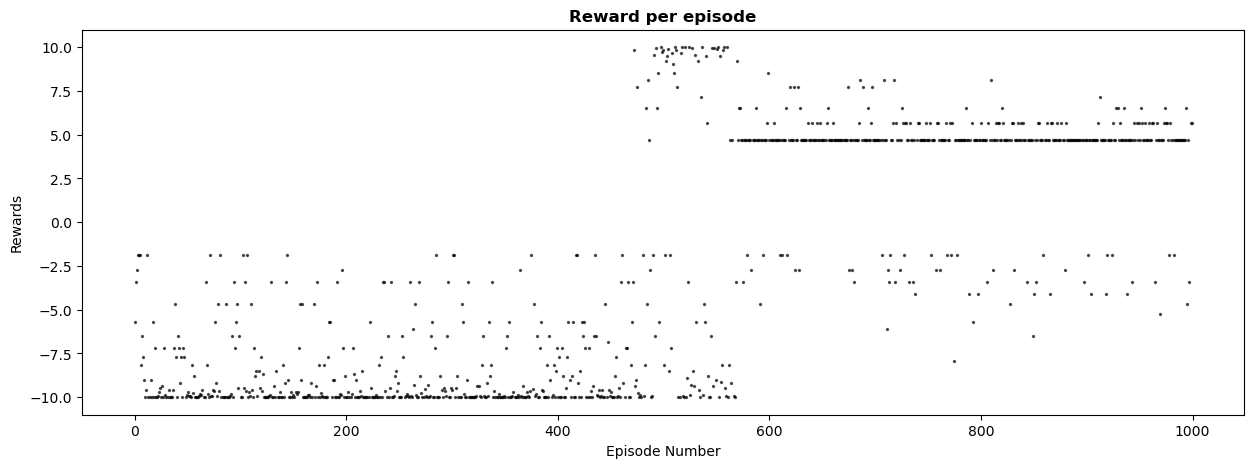

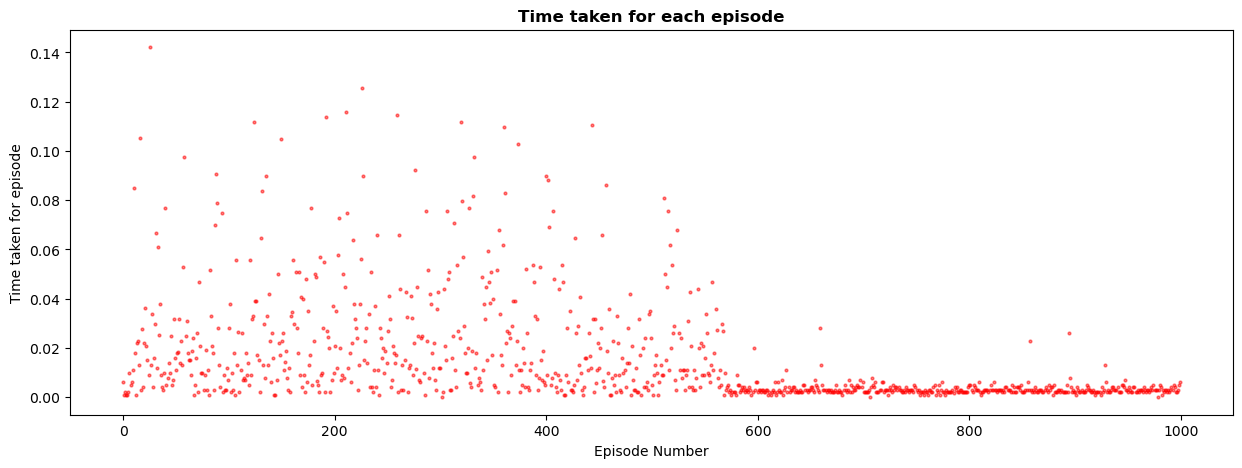

In [524]:
# Epsilon = 0.001
    # Total time for entire simulation -> 3 minute 46.3 seconds
    # Refer to report for further results

# Epsilon = 1 : Only Exploration
    # Total time for entire simulation -> 1.5 seconds
    # Refer to report for further results

monte_data = pd.DataFrame(data = monte1.results).transpose()
col_rename = {monte_data.columns[0] : 'Time taken', 
              monte_data.columns[1] : 'End State Visited?', 
              monte_data.columns[2] : 'Number of states visited',
              monte_data.columns[3] : 'Total Rewards'}

monte_data = monte_data.rename(columns =  col_rename)

y = monte_data['Time taken']
x = pd.Series(range(len(y)))

reward = monte_data['Total Rewards']

# # monte_data.name
print(y.mean())

plt.figure(figsize = (15,5))
plt.scatter(x, reward, s = 2, alpha = 0.6, color = 'black')
plt.xlabel('Episode Number')
plt.ylabel('Rewards')
plt.title('Reward per episode', fontweight = 'bold')

plt.figure(figsize = (15,5))
plt.scatter(x, y, s = 4, alpha = 0.5, color = 'red')
# plt.plot(y)
# plt.yscale('log', base = 2)
plt.xlabel('Episode Number')
plt.ylabel('Time taken for episode')
plt.title('Time taken for each episode', fontweight = 'bold')
plt.show()

In [509]:
monte_data.to_csv(r'C:\Users\moses\Documents\Git\ME5406 Project 1\Figure2_Monte_Carlo_Env2.csv')
# monte_data

### Extended Implementation

##### Creating instance of class & running simulation (Environment 2)

In [580]:
max_epsilon_monte2 = 1 # Max Epsilon
min_epsilon_monte2 = 0.1 # Min Epsilon
decay_rate_monte2 = 0.0005 # Decay rate of epsilon

gamma_monte2 = 0.9 # Rewards discount rate gamma
no_of_episodes_monte2 = 8000 # Number of episodes to be executed in simulation

In [581]:
# Create instance of class with environment 2 (10x10 grid)
monte2 = monte_carlo_sim(env2)

# Run Monte Carlo simulation
monte2.simulate_better(no_of_episodes_monte2, max_epsilon_monte2, min_epsilon_monte2, decay_rate_monte2, gamma_monte2)


'Progress: 3982 / 8000'

#####  Qtable Results for *Monte Carlo Simulation* (Environment 2)

In [ ]:
monte2.fetchQtable()

,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
D,-1.000000,-0.430256,-1.000000,-0.205991,0,0,0,0.000000e+00,-0.729000,-0.430467,0,-0.551466,0,-0.181763,-0.202065,-0.218819,-0.394447,0,-0.207947,-0.097696,-1.000000,-1.000000,0,-0.135124,-0.321867,-1.000000,-1.000000,-1.000000,-0.111587,-0.032685,0,0,-1.000000,-0.265850,-0.343786,0,0,0,-0.810000,-0.405655,-0.729,0,0,-0.207156,-0.164655,-0.335581,-0.400814,0,-0.900000,-1.000000,-0.656100,-0.38742,-0.582843,-0.416063,-1.000000,-1.000000,-0.813000,-0.65610,0.0000,0,0.00000,0.000000,-0.422423,-0.810000,0,0,-0.900000,-1.000000,-1.00000,0.0000,0.000000,0.000000,-1.000000,-0.224448,0,0,0,0,0,0,0,0,0,-0.348678,0,-0.6561,0.0,0,0,0,0,0,0,0.00000,0.000000,0.000000,0.00,0,0,0
U,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000e+00,0.000000,0.000000,0,-0.235093,0,-0.329321,-1.000000,-1.000000,-1.000000,0,-0.810000,-0.193714,-1.000000,-0.279955,0,-0.264420,-0.244202,-0.283311,-0.243644,-1.000000,-0.411965,-0.200507,0,0,-1.000000,-0.159772,-0.243991,0,0,0,-0.656100,-0.026540,0.000,0,0,-0.277050,-0.293468,-1.000000,-1.000000,0,-0.261463,-0.095236,0.000000,-0.90000,-1.000000,-0.189352,-0.154116,-0.261832,-0.533386,-1.00000,-0.8100,0,-0.59049,0.000000,-0.521405,-0.531441,0,0,-0.810000,-0.729000,0.00000,0.0000,-0.531441,0.000000,-0.367752,-0.729000,-1,0,0,0,0,0,0,0,0,-0.150095,0,0.0000,0.0,0,0,0,0,0,0,0.00000,0.000000,0.000000,-0.81,0,0,0
L,0.000000,-0.416172,-0.227447,-0.326358,0,0,0,-1.000000e+00,-0.900000,-0.000005,0,-1.000000,0,-1.000000,-0.354105,-0.350615,-0.201447,0,-1.000000,-0.195589,0.000000,-0.737796,0,-1.000000,-0.396310,-0.174718,-0.336029,-0.900000,-0.480880,-0.531441,0,0,-1.000000,-0.255541,-0.146920,0,0,0,-1.000000,-0.127701,0.000,0,0,-1.000000,-0.374632,-0.366072,-0.262169,0,-1.000000,-0.900000,0.000000,-0.38742,-0.502452,-0.344272,-0.347624,-0.408183,-0.299292,-0.59049,-0.6561,0,0.00000,0.000000,-0.478297,-0.294217,0,0,-1.000000,0.000000,-0.90000,-0.6561,0.000000,-0.478297,-0.430467,-0.900000,0,0,-1,0,0,0,0,0,0,0.000000,0,0.0000,-0.9,0,0,0,0,0,0,0.00000,0.000000,-0.478297,0.00,0,0,0
R,-0.254292,-0.256969,-0.331379,-1.000000,0,0,0,-1.472002e-16,-0.000005,0.000000,0,-1.000000,0,-0.313115,-0.354529,-0.362153,-1.000000,0,-0.810000,0.000000,-0.733578,-1.000000,0,-0.216934,-0.181753,-0.287943,-0.286161,-0.210063,-0.478297,0.000000,0,0,-0.135601,-0.245136,-1.000000,0,0,0,-0.077917,0.000000,0.000,-1,0,-0.149491,-0.383068,-0.257547,-1.000000,0,-0.900000,0.000000,-0.430467,-0.90000,-0.039441,-0.499479,-0.249242,-0.333553,-0.673977,-0.72900,-1.0000,0,0.00000,-0.430467,-0.729000,-1.000000,0,0,-0.478297,-0.531441,-0.59049,0.0000,0.000000,-0.590490,-0.469265,-0.900000,0,0,0,0,0,0,0,0,0,0.000000,0,0.0000,0.0,0,0,0,0,0,0,-0.38742,-0.430467,0.000000,0.00,0,0,0


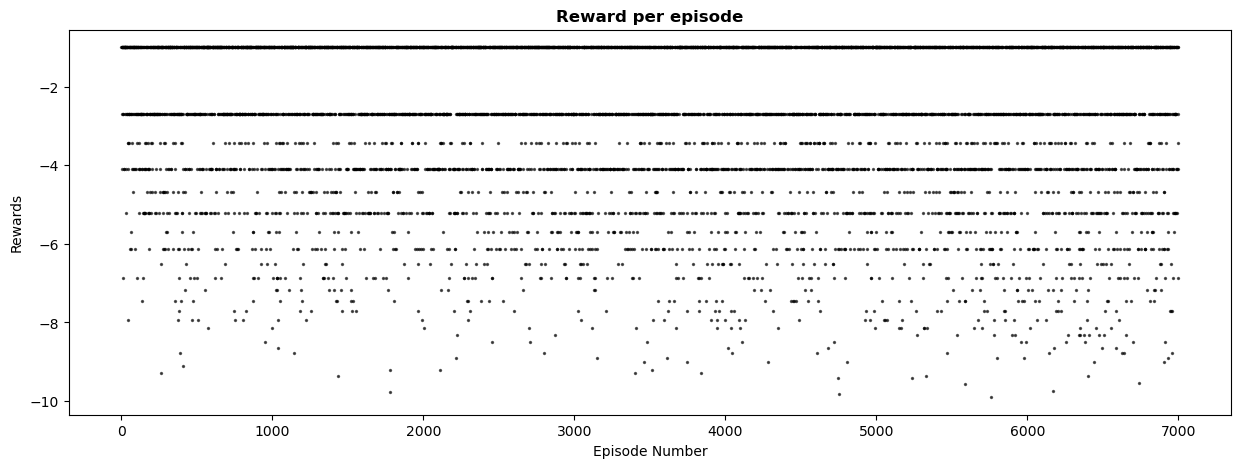

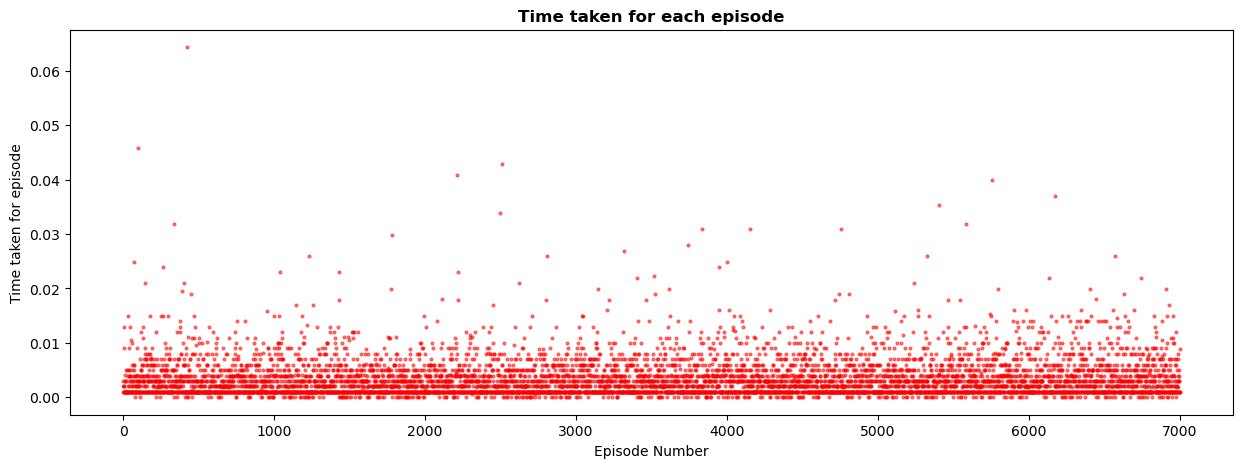

In [536]:
# Epsilon = 0.001
    # Total time for entire simulation -> 3 minute 46.3 seconds
    # Refer to report for further results

# Epsilon = 1 : Only Exploration
    # Total time for entire simulation -> 1.5 seconds
    # Refer to report for further results

monte2_data = pd.DataFrame(data = monte2.results).transpose()
col_rename = {monte2_data.columns[0] : 'Time taken', 
              monte2_data.columns[2] : 'Number of states visited',
              monte2_data.columns[1] : 'End State Visited?', 
              monte2_data.columns[3] : 'Total Rewards'}

monte2_data = monte2_data.rename(columns =  col_rename)

y = monte2_data['Time taken']
x = pd.Series(range(len(y)))

reward = monte2_data['Total Rewards']

# print(y.mean())

plt.figure(figsize = (15,5))
plt.scatter(x, reward, s = 2, alpha = 0.6, color = 'black')
plt.xlabel('Episode Number')
plt.ylabel('Rewards')
plt.title('Reward per episode', fontweight = 'bold')

plt.figure(figsize = (15,5))
plt.scatter(x, y, s = 4, alpha = 0.5, color = 'red')
# plt.plot(y)
# plt.yscale('log', base = 2)
plt.xlabel('Episode Number')
plt.ylabel('Time taken for episode')
plt.title('Time taken for each episode', fontweight = 'bold')
plt.show()

_______________________________________________________________________________________________________________________________

# SARSA with ϵ-Greedy Behavior Policy

###  Algorithm Class

In [385]:
class SARSA_sim:
    '''
    ** Please remember to reset Q and Returns table after simulation

        Functions:
        # Fetches Qtable ->                            .fetchQtable()    
        # Run simulation ->                            .simulate(no_of_episodes, epsilon, gamma)
        # Resets Qtable  ->                            .resettable()      
    '''
    def __init__(self, env):
        self.env = env
        # Create Q table upon creating class
        self.Qtable_sarsa = create_qtable(self.env.rows, self.env.cols, action_space)
        self.results = {}
        self.number_of_states = self.env.rows * self.env.cols
        
    # Returns Qtable    
    def fetchQtable(self):
        return self.Qtable_sarsa
    
    # Resets Qtable by creating an empty table
    def resettable(self):
        self.Qtable_sarsa = create_qtable(self.env.rows, self.env.cols, action_space)
    
    # Run SARSA simulation
    # There will be a sub step simulation within the overarching simulation - for looking ahead and updating Qtable
    def simulate(self, no_of_episodes, epsilon, gamma, alpha):
        self.resettable()       
        self.results = {} # Reset results dictionary
        visited = set() # Create set for visited states

        for i in range(no_of_episodes):  
            # Show progress of episodes  
            clear_output(wait = True)
            display('Progress: {} / {}'.format(i+1, no_of_episodes))

            # reset environment to start state
            self.env.reset()  

            ## Code for results analysis
            found_reward = False
            start_time = time.time() # Record start time of simulation

            # Loop for main simulation
            while self.env.is_terminal(self.env.current_state()) == False:
                # Assign state so that it can be referenced again later after sub step simulation is conducted
                main_step_state = self.env.current_state()
                # print('Main Step: {}'.format(main_step_state))


                # Loop for sub simulation - Looking ahead until agent reaches terminal state 
                while self.env.is_terminal(self.env.current_state()) == False:
                    sub_step_state = self.env.current_state()
                    state_formatted = str(sub_step_state[0]) + str(sub_step_state[1])
                    # Choose action in sub step simulation
                    sub_step_action = epsilon_soft(self.Qtable_sarsa, self.env, epsilon, sub_step_state)
                    # print('Sub step state: {}, Sub step action: {}'.format(sub_step_state, sub_step_action))

                    # Taking action - to observe next state, action and reward
                    self.env.move(sub_step_action)

                    # Retrieve reward for taking specific action
                    reward = self.env.get_rewards()

                    # Code to check if end state was found - for results analysis
                    if reward == 1:
                        found_reward = True

                    # Retrieve new state
                    new_sub_step_state = self.env.current_state()
                    new_state_formatted = str(new_sub_step_state[0]) + str(new_sub_step_state[1])

                    # Add visited state to visited set for results analysis
                    visited.add(new_sub_step_state)

                    # self.env.render() # Uncomment if you want to render visualisation

                    # print("Sub State: {}\nSub Action: {}\n\n".format(sub_step_state, sub_step_action)) ## Test print

                    # Check if new state is a terminal state: If not, then retrieve action for new state
                    if new_sub_step_state in self.env.actions:
                        new_sub_step_action = epsilon_soft(self.Qtable_sarsa, self.env, epsilon, new_sub_step_state)
                        
                        # Update Q(s1, a1) in direction of Q(s2, a2)
                        self.Qtable_sarsa.loc[sub_step_action, state_formatted] += (alpha * (reward + (gamma * self.Qtable_sarsa.at[new_sub_step_action, new_state_formatted]) - self.Qtable_sarsa.at[sub_step_action, state_formatted]))
                        # print('State formatted (regular state): {}, Action: {}, Q Value: {}'.format(state_formatted, sub_step_action, (alpha * (reward + (gamma * self.Qtable_sarsa.at[new_sub_step_action, new_state_formatted]) - self.Qtable_sarsa.at[sub_step_action, state_formatted]))))
                    # If state is a terminal state, then update Q(s1, a1) with same equation, but Q(s2, a2) = 0 (since terminal state)
                    else:
                        self.Qtable_sarsa.loc[sub_step_action, state_formatted] += (alpha * (reward + (gamma * 0) - self.Qtable_sarsa.at[sub_step_action, state_formatted]))
                        # print('State formatted (hole): {}, Action: {},  Q Value: {}'.format(state_formatted, sub_step_action, (alpha * (reward + (gamma * 0) - self.Qtable_sarsa.at[sub_step_action, state_formatted]))))
                        break # break out of sub simulation since it has reached terminal state
                            

                # Since we now want to revert back to the main simulation, we will need to reassign agent back to the main state  
                self.env.set_state(main_step_state)
                # Choose action based on policy with new Q values updated by sub simulation
                main_step_action = epsilon_soft(self.Qtable_sarsa, self.env, epsilon, main_step_state)

                # Move agent
                self.env.move(main_step_action) 

                # print("Main state: {}\nMain Action: {}".format(main_step_state, main_step_action)) ## Test print
            
            # For results analysis
            end_time = time.time() # record end time of simulation
            elapsed_time = end_time - start_time
            episode_number = i + 1
            self.results[episode_number] = [elapsed_time, found_reward, '{} / {}'.format(len(visited), self.number_of_states)]

        # Uncomment if render is uncommented
        # pygame.quit()   
    
    # Run SARSA simulation BETTER
    # There will be a sub step simulation within the overarching simulation - for looking ahead and updating Qtable
    def simulate_better(self, no_of_episodes, max_steps, max_epsilon, min_epsilon, decay_rate, gamma, alpha):                
        self.resettable()
        self.results = {} # Reset results dictionary
        visited = set() # Create set for visited states

        for i in range(no_of_episodes):    
            # Show progress of episodes  
            clear_output(wait = True)
            display('Progress: {} / {}'.format(i+1, no_of_episodes))

            # reset environment to start state
            self.env.reset()  

            ## Code for results analysis
            found_reward = False
            start_time = time.time() # Record start time of simulation

            # Set epsilon that decays with number of episodes
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*math.exp(-decay_rate*i) 

            # Loop for main simulation
            while self.env.is_terminal(self.env.current_state()) == False:
                # Assign state so that it can be referenced again later after sub step simulation is conducted
                main_step_state = self.env.current_state()
                # print('Main Step: {}'.format(main_step_state))
                
                # Loop for sub simulation - Looking ahead until agent reaches terminal state 
                while self.env.is_terminal(self.env.current_state()) == False:
                    for j in range(max_steps):
                        sub_step_state = self.env.current_state()
                        state_formatted = str(sub_step_state[0]) + str(sub_step_state[1])
                        # Choose action in sub step simulation
                        sub_step_action = epsilon_soft(self.Qtable_sarsa, self.env, epsilon, sub_step_state)
                        # print('Sub step state: {}, Sub step action: {}'.format(sub_step_state, sub_step_action))
                        
                        # Taking action - to observe next state, action and reward
                        self.env.move(sub_step_action)

                        # Retrieve reward for taking specific action
                        reward = self.env.get_rewards()

                        # Code to check if end state was found - for results analysis
                        if reward == 1:
                            found_reward = True

                        # Retrieve new state
                        new_sub_step_state = self.env.current_state()
                        new_state_formatted = str(new_sub_step_state[0]) + str(new_sub_step_state[1])
                        
                        # Add visited state to visited set
                        visited.add(new_sub_step_state)
                        
                        # self.env.render() # Used to render visualisation

                        # print("Sub State: {}\nSub Action: {}\n\n".format(sub_step_state, sub_step_action)) ## Test print

                        # Check if new state is a terminal state: If not, then retrieve action for new state
                        if new_sub_step_state in self.env.actions:
                            new_sub_step_action = epsilon_soft(self.Qtable_sarsa, self.env, epsilon, new_sub_step_state)
                            
                            # Update Q(s1, a1) in direction of Q(s2, a2)
                            self.Qtable_sarsa.loc[sub_step_action, state_formatted] += (alpha * (reward + (gamma * self.Qtable_sarsa.at[new_sub_step_action, new_state_formatted]) - self.Qtable_sarsa.at[sub_step_action, state_formatted]))
                            # print('State formatted (regular state): {}, Action: {}, Q Value: {}'.format(state_formatted, sub_step_action, (alpha * (reward + (gamma * self.Qtable_sarsa.at[new_sub_step_action, new_state_formatted]) - self.Qtable_sarsa.at[sub_step_action, state_formatted]))))
                        # If state is a terminal state, then update Q(s1, a1) with same equation, but Q(s2, a2) = 0 (since terminal state)
                        else:
                            self.Qtable_sarsa.loc[sub_step_action, state_formatted] += (alpha * (reward + (gamma * 0) - self.Qtable_sarsa.at[sub_step_action, state_formatted]))
                            # print('State formatted (hole): {}, Action: {},  Q Value: {}'.format(state_formatted, sub_step_action, (alpha * (reward + (gamma * 0) - self.Qtable_sarsa.at[sub_step_action, state_formatted]))))
                            break # break out of sub simulation since it has reached terminal state
                    break
                # print(self.Qtable_sarsa)

                # Since we now want to revert back to the main simulation, we will need to reassign agent back to the main state  
                self.env.set_state(main_step_state)
                # Choose action based on policy with new Q values updated by sub simulation
                main_step_action = epsilon_soft(self.Qtable_sarsa, self.env, epsilon, main_step_state)

                # Move agent
                self.env.move(main_step_action)

                # print("Main state: {}\nMain Action: {}".format(main_step_state, main_step_action)) ## Test print
                
            # For results analysis
            end_time = time.time() # record end time of simulation
            elapsed_time = end_time - start_time
            episode_number = i + 1
            self.results[episode_number] = [elapsed_time, found_reward, '{} / {}'.format(len(visited), self.number_of_states)]

            # Uncomment if render is uncommented
            # pygame.quit()


###  Running Simulation

#####  Defining Parameters

In [450]:
epsilon_sarsa = 0.1 # Epsilon greedy probability 
gamma_sarsa = 0.9 # Rewards discount rate gamma
alpha_sarsa = 0.3 # Learning rate of agent
no_of_episodes_sarsa = 1000# Number of episodes to be executed in simulation

#####  Creating instance of class & running simulation (Environment 1)

In [451]:
# Create instance of class with environment 1 (4x4 grid)
sarsa1 = SARSA_sim(env1)

# Run SARSA simulation
sarsa1.simulate(no_of_episodes_sarsa, epsilon_sarsa, gamma_sarsa, alpha_sarsa)

'Progress: 156 / 1000'

KeyboardInterrupt: 

#####  Qtable Results for *SARSA with ϵ-Greedy Behavior Policy* (Environment 1)

In [388]:
sarsa1.fetchQtable()

,00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
D,-0.010659,-0.999968,0.723765,-0.996677,0.185127,0,0.809660,0,-0.998860,0.752365,0.899982,0,0,0.000000,0.000000,0
U,0.000000,0.000000,0.000000,0.000000,0.198259,0,0.390290,0,-0.069598,-0.980227,0.569630,0,0,0.576606,0.762356,0
L,0.000000,0.171836,0.190674,0.203214,0.000000,0,-0.998860,0,0.000000,0.378328,0.193923,0,0,-0.990311,0.743429,0
R,0.261839,0.619838,0.199418,0.000000,-0.995252,0,-0.999977,0,0.599317,0.445209,-0.999998,0,0,0.884783,1.000000,0


0.03938720146814982


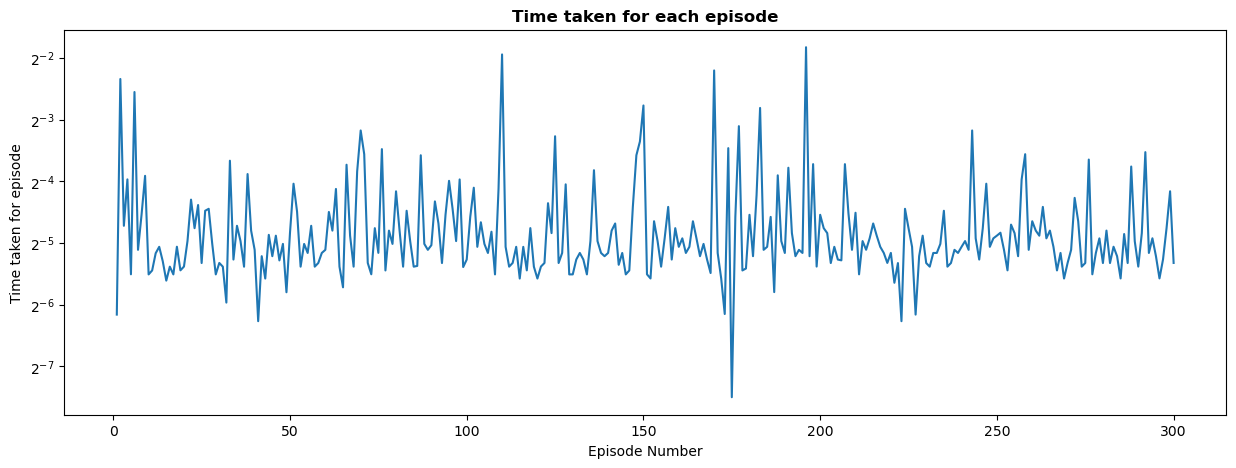

In [389]:
# Epsilon = 0.001
    # Total time for entire simulation -> 3 minute 46.3 seconds
    # Refer to report for further results

# Epsilon = 1 : Only Exploration
    # Total time for entire simulation -> 1.5 seconds
    # Refer to report for further results

sarsa1_data = pd.DataFrame(data = sarsa1.results).transpose()
col_rename = {sarsa1_data.columns[0] : 'Time taken', sarsa1_data.columns[1] : 'End State Visited?', sarsa1_data.columns[2] : 'Number of states visited' }

sarsa1_data = sarsa1_data.rename(columns =  col_rename)

y = sarsa1_data['Time taken']
# monte_data.name
print(y.mean())

plt.figure(figsize = (15,5))
plt.plot(y)
plt.yscale('log', base = 2)
plt.xlabel('Episode Number')
plt.ylabel('Time taken for episode')
plt.title('Time taken for each episode', fontweight = 'bold')
plt.show()

In [147]:
sarsa1.results

{1: [0.278242826461792, True, '16 / 16'],
 2: [0.05585074424743652, True, '16 / 16'],
 3: [0.024933815002441406, True, '16 / 16'],
 4: [0.029932498931884766, True, '16 / 16'],
 5: [0.03690695762634277, True, '16 / 16'],
 6: [0.020943164825439453, True, '16 / 16'],
 7: [0.02898263931274414, True, '16 / 16'],
 8: [0.023935556411743164, True, '16 / 16'],
 9: [0.03192734718322754, True, '16 / 16'],
 10: [0.0199739933013916, True, '16 / 16'],
 11: [0.034934043884277344, True, '16 / 16'],
 12: [0.02895212173461914, True, '16 / 16'],
 13: [0.034906864166259766, True, '16 / 16'],
 14: [0.08876204490661621, True, '16 / 16'],
 15: [0.032216548919677734, True, '16 / 16'],
 16: [0.03592085838317871, True, '16 / 16'],
 17: [0.025929689407348633, True, '16 / 16'],
 18: [0.030431270599365234, True, '16 / 16'],
 19: [0.028924226760864258, True, '16 / 16'],
 20: [0.020942211151123047, True, '16 / 16'],
 21: [0.026929140090942383, True, '16 / 16'],
 22: [0.05922436714172363, True, '16 / 16'],
 23: [0.03

### Extended Implementation

#####  Creating instance of class & running simulation (Environment 2)

In [277]:
epsilon_sarsa2 = 1 # Epsilon greedy probability
epsilon_max2 = 1 # Max epsilon value
epsilon_min2 = 0.001 # Min epsilon value
ep_decay_rate2 = 0.005 # Exponential decay rate for exploration probability
max_steps2 = len(action_space) * env2.rows * 2

gamma_sarsa2 = 0.9 # Rewards discount rate gamma
alpha_sarsa2 = 0.3 # Learning rate of agent
no_of_episodes_sarsa2 = 300# Number of episodes to be executed in simulation

In [278]:
# Create instance of class with environment 1 (10x10 grid)
sarsa2 = SARSA_sim(env2)

# Run SARSA simulation
sarsa2.simulate_better(no_of_episodes_sarsa2, max_steps2, epsilon_max2, epsilon_min2, ep_decay_rate2, gamma_sarsa, alpha_sarsa2)

'Progress: 300 / 300'

#####  Qtable Results for *SARSA with ϵ-Greedy Behavior Policy* (Environment 2)

In [279]:
sarsa2.fetchQtable()

,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
D,-1.000000,-0.401577,-1.000000,-0.239629,0,0,0,-0.990311,-0.047732,-0.023405,0,-0.445986,0,-0.100834,-0.313409,-0.403292,-0.166956,0,-0.105216,-0.036121,-0.997674,-0.999999,0,-0.138326,-0.207184,-0.999999,-0.999202,-0.997674,-0.227759,-0.042242,0,0,-0.996677,-0.098849,-0.243445,0,0,0,-0.136409,-0.125455,-0.038404,-0.036646,0,-0.063197,-0.301198,-0.262533,-0.350504,0,-0.131429,-0.959646,-0.021515,-0.032551,-0.034199,-0.032170,-1.000000,-0.993218,-0.421700,-0.243651,-0.299201,0,-0.126005,-0.108298,-0.039159,-0.119110,0,0,-0.484916,-0.942352,-0.882351,-0.056700,-0.304052,-0.236095,-1.000000,-0.238443,-0.831930,0,-0.240895,0,0,0.08100,-1.000000,-0.352113,0,-0.190243,0,-0.204748,-0.210772,0,0.0,0.51,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0,0
U,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000,0.000000,0,-0.387639,0,-0.426025,-1.000000,-0.999441,-0.959646,0,-0.030017,-0.023671,-0.996677,-0.585942,0,-0.304270,-0.408601,-0.323722,-0.304896,-0.999726,-0.287718,-0.027236,0,0,-0.986159,-0.434765,-0.286631,0,0,0,-0.026834,-0.027669,-1.000000,-1.000000,0,-0.181078,-0.202590,-0.999992,-0.942352,0,-0.140686,-0.029549,-0.061502,-0.124548,-1.000000,-0.192587,-0.266676,-0.342586,-0.519056,-0.959646,-0.091720,0,-0.021007,-0.075374,-0.056400,-0.122596,0,0,-0.325624,-0.423554,-0.095895,-0.657000,-0.027507,-0.035118,-0.086429,-0.137780,-0.942352,0,-0.404070,0,0,-0.00901,-0.044123,-0.092392,0,-0.255722,0,-0.882351,-0.243576,0,0.0,0.00,0,-0.047451,-0.971752,-0.280322,-0.996677,-0.163427,-0.401455,0,0.0,0
L,0.000000,-0.522973,-0.373871,-0.416784,0,0,0,-0.995252,-0.167725,-0.037379,0,-1.000000,0,-1.000000,-0.330164,-0.248732,-0.360135,0,-1.000000,-0.038308,0.000000,-0.629254,0,-1.000000,-0.391978,-0.307757,-0.437785,-0.162817,-0.039473,-0.073194,0,0,-0.997674,-0.347215,-0.097043,0,0,0,-0.999726,-0.046115,0.000000,-0.071293,0,-1.000000,-0.325245,-0.181947,-0.559903,0,-0.882351,-0.087413,0.000000,-0.061634,-0.094831,-0.294010,-0.065039,-0.268462,-0.397178,-0.315435,-0.289458,0,0.000000,-0.028520,-0.051193,-0.035736,0,0,-0.998860,-0.247077,-0.111298,-0.062567,0.000000,-0.045862,-0.033931,-0.305875,-0.142068,0,-0.980227,0,0,-0.30000,0.000000,-0.186796,0,-0.997674,0,-0.971752,-0.338306,0,0.0,0.00,0,-0.995252,-0.332852,-0.393732,-0.223570,-0.336502,-0.227475,0,0.0,0
R,-0.353715,-0.384519,-0.218674,-1.000000,0,0,0,-0.062587,-0.036699,0.000000,0,-1.000000,0,-0.467481,-0.314438,-0.487823,-0.959646,0,-0.038013,0.000000,-0.571609,-0.999808,0,-0.238810,-0.467522,-0.193221,-0.045652,-0.028674,-0.028989,0.000000,0,0,-0.237443,-0.421680,-1.000000,0,0,0,-0.140185,0.000000,-0.076704,-1.000000,0,-0.240795,-0.341213,-0.305385,-0.959646,0,-0.050292,0.000000,-0.047504,-0.130496,-0.075266,-0.148220,-0.305894,-0.329621,-0.349938,-0.293316,-0.917646,0,-0.033693,-0.041275,-0.293614,-1.000000,0,0,-0.300005,-0.316858,-0.073683,0.000000,-0.115000,-0.144145,-0.056993,-0.291163,-0.959646,0,-0.759900,0,0,0.00000,-0.162456,-1.000000,0,-0.990311,0,-0.168583,-0.917646,0,0.0,0.00,0,-0.311514,-0.204191,-0.185454,-0.183320,-0.398624,-0.986159,0,0.0,0


In [280]:
sarsa2.results

{1: [0.07978630065917969, False, '16 / 100'],
 2: [0.0064923763275146484, False, '16 / 100'],
 3: [0.052875518798828125, False, '18 / 100'],
 4: [0.02892160415649414, False, '18 / 100'],
 5: [0.01994633674621582, False, '19 / 100'],
 6: [0.0039882659912109375, False, '19 / 100'],
 7: [0.004987239837646484, False, '19 / 100'],
 8: [0.03789925575256348, False, '19 / 100'],
 9: [0.006981372833251953, False, '19 / 100'],
 10: [0.008976221084594727, False, '20 / 100'],
 11: [0.001995086669921875, False, '20 / 100'],
 12: [0.01296544075012207, False, '20 / 100'],
 13: [0.03390932083129883, False, '20 / 100'],
 14: [0.02094411849975586, False, '20 / 100'],
 15: [0.01894974708557129, False, '20 / 100'],
 16: [0.011968135833740234, False, '20 / 100'],
 17: [0.05884242057800293, False, '20 / 100'],
 18: [0.016954421997070312, False, '20 / 100'],
 19: [0.02393651008605957, False, '20 / 100'],
 20: [0.008975505828857422, False, '20 / 100'],
 21: [0.008977174758911133, False, '20 / 100'],
 22: [0.0

In [ ]:
env2.rewards

{(9, 9): 1,
 (4, 5): -1,
 (4, 0): -1,
 (5, 0): -1,
 (6, 3): -1,
 (1, 6): -1,
 (4, 9): -1,
 (3, 6): -1,
 (0, 8): -1,
 (3, 7): -1,
 (9, 2): -1,
 (3, 5): -1,
 (3, 4): -1,
 (9, 7): -1,
 (1, 0): -1,
 (5, 6): -1,
 (5, 4): -1,
 (7, 2): -1,
 (1, 7): -1,
 (0, 6): -1,
 (6, 4): -1,
 (7, 4): -1,
 (4, 3): -1,
 (0, 4): -1,
 (7, 6): -1,
 (7, 5): -1}

_______________________________________________________________________________________________________________________________

# Qlearning with an ϵ-greedy behavior policy

###  Algorithm Class

In [ ]:
class qlearning_sim:
    '''
    ** Please remember to reset Q and Returns table after simulation

        Functions:
        # Fetches Qtable ->                            .fetchQtable()    
        # Run simulation ->                            .simulate(no_of_episodes, epsilon, gamma)
        # Resets Qtable  ->                            .resettable()      
    '''
    def __init__(self, env):
        self.env = env
        # Create Q table upon creating class
        self.Qtable_qlearning = create_qtable(self.env.rows, self.env.cols, action_space)
        
    # Returns Qtable    
    def fetchQtable(self):
        return self.Qtable_qlearning
    
    # Resets Qtable by creating an empty table
    def resettable(self):
        self.Qtable_qlearning = create_qtable(self.env.rows, self.env.cols, action_space)
    
    # Run Qlearning simulation
            # There will be a sub step simulation within the overarching simulation - for looking ahead and updating Qtable
    def simulate(self, no_of_episodes, epsilon, gamma, alpha):
        self.resettable()        
        for i in range(no_of_episodes):    
            print('Episode Number: {} / {}'.format(i + 1, no_of_episodes))

            # reset environment to start state
            self.env.reset()  

            # Initiialise main simulation state
            main_step_state = self.env.current_state()

            # Loop for main simulation
            while self.env.is_terminal(self.env.current_state()) == False:
                # Assign state so that it can be referenced again later after sub step simulation is conducted
                main_step_state = self.env.current_state()

                # Loop for sub simulation - Looking ahead until agent reaches terminal state 
                while self.env.is_terminal(self.env.current_state()) == False:
                    sub_step_state = self.env.current_state()
                    state_formatted = str(sub_step_state[0]) + str(sub_step_state[1])
                    # Choose action in sub step simulation
                    sub_step_action = epsilon_soft(self.Qtable_qlearning, self.env, epsilon, sub_step_state)
                    
                    # Taking action - to observe next state, action and rewar
                    self.env.move(sub_step_action)

                    # Retrieve reward for taking specific action
                    reward = self.env.get_rewards()
                    # Retrieve new state
                    new_sub_step_state = self.env.current_state()
                    new_state_formatted = str(new_sub_step_state[0]) + str(new_sub_step_state[1])

                    # print("Sub State: {}\nSub Action: {}\n\n".format(sub_step_state, sub_step_action)) ## Test print

                    # Check if new state is a terminal state: If not, then retrieve action for new state
                    if new_sub_step_state in self.env.actions:
                        new_sub_step_action = epsilon_soft(self.Qtable_qlearning, self.env, epsilon, new_sub_step_state)
                        
                        # Update Q(s1, a1) in direction of Q(s2, a2) where Q(s2, a2) is max qvalue at state s2
                        self.Qtable_qlearning.loc[sub_step_action, state_formatted] += (alpha * (reward + (gamma * self.Qtable_qlearning[new_state_formatted].max()) - self.Qtable_qlearning.at[sub_step_action, state_formatted]))

                    # If state is a terminal state, then update Q(s1, a1) with same equation, but Q(s2, a2) = 0 (since terminal state)
                    else:
                        self.Qtable_qlearning.loc[sub_step_action, state_formatted] += (alpha * (reward + (gamma * 0) - self.Qtable_qlearning.at[sub_step_action, state_formatted]))
                        break # break out of sub simulation since it has reached terminal state

                # Since we now want to revert back to the main simulation, we will need to reassign agent back to the main state  
                self.env.set_state(main_step_state)
                # Choose action based on policy with new Q values updated by sub simulation
                main_step_action = epsilon_soft(self.Qtable_qlearning, self.env, epsilon, main_step_state)
                # Move agent
                self.env.move(main_step_action) 

                # print("Main state: {}\nMain Action: {}".format(main_step_state, main_step_action)) ## Test print

###  Running Simulation

#####  Defining Parameters

In [ ]:
epsilon_qlearning = 0.1 # Epsilon greedy probability 
gamma_qlearning = 0.9 # Rewards discount rate gamma
alpha_qlearning = 0.3 # Learning rate of agent
no_of_episodes_qlearning = 100 # Number of episodes to be executed in simulation

#####  Creating instance of class & running simulation (Environment 1)

In [ ]:
# Create instance of class with environment 1 (4x4 grid)
qlearning1 = qlearning_sim(env1)

# Run Qlearning simulation
qlearning1.simulate(no_of_episodes_qlearning, epsilon_qlearning, gamma_qlearning, alpha_qlearning)

Episode Number: 1 / 100
Episode Number: 2 / 100
Episode Number: 3 / 100
Episode Number: 4 / 100
Episode Number: 5 / 100
Episode Number: 6 / 100
Episode Number: 7 / 100
Episode Number: 8 / 100
Episode Number: 9 / 100
Episode Number: 10 / 100
Episode Number: 11 / 100
Episode Number: 12 / 100
Episode Number: 13 / 100
Episode Number: 14 / 100
Episode Number: 15 / 100
Episode Number: 16 / 100
Episode Number: 17 / 100
Episode Number: 18 / 100
Episode Number: 19 / 100
Episode Number: 20 / 100
Episode Number: 21 / 100
Episode Number: 22 / 100
Episode Number: 23 / 100
Episode Number: 24 / 100
Episode Number: 25 / 100
Episode Number: 26 / 100
Episode Number: 27 / 100
Episode Number: 28 / 100
Episode Number: 29 / 100
Episode Number: 30 / 100
Episode Number: 31 / 100
Episode Number: 32 / 100
Episode Number: 33 / 100
Episode Number: 34 / 100
Episode Number: 35 / 100
Episode Number: 36 / 100
Episode Number: 37 / 100
Episode Number: 38 / 100
Episode Number: 39 / 100
Episode Number: 40 / 100
Episode N

#####  Qtable Results for *Qlearning with ϵ-Greedy Behavior Policy* (Environment 1)

In [ ]:
qlearning1.fetchQtable()

,00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
D,0.590490,-0.300000,0.728223,-0.51,0.656100,0,0.810000,0,-0.995252,0.670113,0.900000,0,0,0.00000,0.000000,0
U,0.000000,0.000000,0.000000,0.00,0.468749,0,0.326947,0,0.578814,-0.990311,0.727777,0,0,0.00000,0.808843,0
L,0.000000,0.000000,0.129427,0.00,0.000000,0,-0.510000,0,0.000000,0.649230,0.727304,0,0,-0.51000,0.803441,0
R,0.436613,0.635228,0.000000,0.00,-0.959646,0,-0.759900,0,0.729000,0.810000,-0.882351,0,0,0.89995,1.000000,0


### Extended Implementation

#####  Creating instance of class & running simulation (Environment 2)

In [ ]:
epsilon_qlearning2 = 0.1 # Epsilon greedy probability 
gamma_qlearning2 = 0.9 # Rewards discount rate gamma
alpha_qlearning2 = 0.3 # Learning rate of agent
no_of_episodes_qlearning2 = 100 # Number of episodes to be executed in simulation

In [ ]:
# Create instance of class with environment 1 (4x4 grid)
qlearning2 = qlearning_sim(env2)

# Run Qlearning simulation
qlearning2.simulate(no_of_episodes_qlearning2, epsilon_qlearning2, gamma_qlearning2, alpha_qlearning2)

Episode Number: 1 / 100
Episode Number: 2 / 100
Episode Number: 3 / 100
Episode Number: 4 / 100
Episode Number: 5 / 100
Episode Number: 6 / 100
Episode Number: 7 / 100
Episode Number: 8 / 100
Episode Number: 9 / 100
Episode Number: 10 / 100
Episode Number: 11 / 100
Episode Number: 12 / 100
Episode Number: 13 / 100
Episode Number: 14 / 100
Episode Number: 15 / 100
Episode Number: 16 / 100
Episode Number: 17 / 100
Episode Number: 18 / 100
Episode Number: 19 / 100
Episode Number: 20 / 100
Episode Number: 21 / 100
Episode Number: 22 / 100
Episode Number: 23 / 100
Episode Number: 24 / 100
Episode Number: 25 / 100
Episode Number: 26 / 100
Episode Number: 27 / 100
Episode Number: 28 / 100
Episode Number: 29 / 100
Episode Number: 30 / 100
Episode Number: 31 / 100
Episode Number: 32 / 100
Episode Number: 33 / 100
Episode Number: 34 / 100
Episode Number: 35 / 100
Episode Number: 36 / 100
Episode Number: 37 / 100
Episode Number: 38 / 100
Episode Number: 39 / 100
Episode Number: 40 / 100
Episode N

#####  Qtable Results for *Qlearning with ϵ-Greedy Behavior Policy* (Environment 2)

In [ ]:
qlearning2.fetchQtable()

,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
D,-0.990311,0.121345,0.099654,0.228768,0,0.282421,0,0,0,0.00,0,0.028191,0.000000,0.194985,0.271978,0.313811,0,0,0.430416,0.000000,0.000000,0.000,0.000000,0.000000,-0.942352,-0.999808,-0.999726,-0.999441,0.478297,0.428397,-0.959646,0.0,0.0,-0.942352,0,0,0,0,0.531441,-0.657000,0,0.0000,0.000000,0,0,0,-0.300000,0.000000,0.590490,0,0,0.000000,0.0,-0.7599,0,0.0,0,0.240937,0.656100,0.668964,0.0000,0.0,-0.7599,0,0,-0.3,-0.300000,0.000000,0.728949,0.810000,0.0,0.00000,0,0.00,0,0,0,0.000000,0.000000,0.900000,0.0,0.0,-0.51,0.0,0.0,0.0,0.0,-0.3,0.31347,1.000000,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0000,0
U,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0,0,0.00,0,0.166772,0.055591,0.201141,-0.998372,0.253922,0,0,-0.510000,0.000000,-0.993218,0.097,0.000000,0.228404,0.000000,0.282392,-0.999906,-0.999202,0.386452,0.000000,0.000000,0.0,0.0,0.061358,0,0,0,0,0.430299,0.000000,0,0.0000,0.000000,0,0,0,-0.300000,-0.300000,0.478110,0,0,0.000000,0.0,-0.5100,0,0.0,0,0.119327,0.531435,-0.657000,-0.7599,0.0,0.0000,0,0,0.0,-0.300000,0.531405,0.590488,0.548703,0.0,0.00000,0,-0.51,0,0,0,0.000000,0.431058,0.729000,0.0,0.0,-0.51,0.0,-0.3,-0.3,0.0,0.0,0.72900,0.809994,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0000,0
L,0.000000,0.141916,0.166211,0.184686,0,-0.882351,0,0,0,-0.51,0,-0.999441,0.150050,0.129722,0.224246,0.254115,0,0,-0.300000,0.115885,0.000000,0.000,0.000000,0.000004,0.000000,0.262794,0.313087,0.348111,0.387135,0.129140,0.000000,0.0,0.0,0.000000,0,0,0,0,-0.993218,0.478297,0,-0.7599,0.000000,0,0,0,-0.300000,0.000000,0.478082,0,0,-0.882351,0.0,0.0000,0,0.0,0,-0.831930,0.531435,0.590490,0.0000,0.0,0.0000,0,0,-0.3,0.000000,0.000000,0.477689,0.656100,0.0,0.00000,0,-0.30,0,0,0,0.000000,0.309534,0.728999,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00000,0.656100,0.0,0.0,0,-0.3,0.0,0.0,0,0,0.0000,0
R,0.166772,0.185302,0.205891,-0.999609,0,-0.831930,0,0,0,0.00,0,0.068842,0.000000,0.254187,0.282430,-0.999984,0,0,0.000000,0.000000,0.000000,0.000,0.047287,0.000000,0.313737,0.348678,0.387420,0.430467,0.374485,0.000000,0.000000,0.0,0.0,-0.882351,0,0,0,0,0.430281,0.000000,0,0.0000,-0.993218,0,0,0,0.143011,0.531429,-0.999992,0,0,0.000000,0.0,-0.7599,0,0.0,0,0.590490,0.531436,0.000000,0.0000,0.0,-0.7599,0,0,0.0,0.143246,0.000000,0.729000,0.000000,0.0,-0.83193,0,-0.30,0,0,0,0.606477,0.810000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.45900,0.000000,0.0,-0.3,0,0.0,0.0,0.0,0,0,0.7599,0


_______________________________________________________________________________________________________________________________

# Analysing Results

### Monte Carlo Simulation

##### Environment 1

In [ ]:
monte1.results

{1: [0.0029964447021484375, False, '2 / 16'],
 2: [0.0009987354278564453, False, '2 / 16'],
 3: [0.0009949207305908203, False, '2 / 16'],
 4: [0.004985809326171875, False, '4 / 16'],
 5: [0.004987955093383789, False, '7 / 16'],
 6: [0.00202178955078125, False, '4 / 16'],
 7: [0.0019943714141845703, False, '5 / 16'],
 8: [0.0019943714141845703, False, '5 / 16'],
 9: [0.000997304916381836, False, '3 / 16'],
 10: [0.003019094467163086, False, '5 / 16'],
 11: [0.0029909610748291016, False, '3 / 16'],
 12: [0.000997304916381836, False, '3 / 16'],
 13: [0.00894927978515625, False, '6 / 16'],
 14: [0.006994724273681641, False, '3 / 16'],
 15: [0.00997018814086914, False, '3 / 16'],
 16: [0.009986639022827148, False, '5 / 16'],
 17: [0.015957117080688477, False, '7 / 16'],
 18: [0.00897526741027832, False, '3 / 16'],
 19: [0.0049877166748046875, False, '4 / 16'],
 20: [0.01195073127746582, False, '6 / 16'],
 21: [0.0050165653228759766, False, '6 / 16'],
 22: [0.00994563102722168, False, '5 / 1

##### Environment 2

### SARSA

### Q learning